In [ ]:
import pandas as pd

hitter_df = pd.read_csv("data_scraping/hitters_data.csv")
pitcher_df = pd.read_csv("data_scraping/pitchers_data.csv")

# Hitter Data EDA

In [ ]:
hitter_df

In [ ]:
hitter_df.info()

Hitter Data:

* Data for 311,340 at bats (abs) over 7 seasons (2015-2021)
* DraftKing information for all 311,340 abs
* FanDuel information for 194,581 of the 311,340 abs
* Yahoo information for 202,836 of the 311,340 abs
* Game stats for each of the at bats
* Information about starter hand for 292,844 of the at bats
* Hit distance for 279,628 of the at bats
* Estimated ba (batting average) and woba (weighted on base average) using statcast metrics for 272,298 at bats
* Change in home win expectancy for 292,844 of the at bats
* Change in run expectancy for 290,396 of the at bats

## Feature Engineering

Remove features not needed

In [ ]:
hitter_df.drop(['Unnamed: 0'], axis=1, inplace=True)
hitter_df.drop(['day'], axis=1, inplace=True)
hitter_df.drop(['month'], axis=1, inplace=True)
hitter_df.drop(['game_pk'], axis=1, inplace=True)
hitter_df.drop(['Stats_Summary'], axis=1, inplace=True)

In [ ]:
hitter_df

Add a home_team column and clean up Opp column

In [ ]:
def is_home_team(match):
    if match.startswith('v'):
        return True
    elif match.startswith('@'):
        return False
    else:
        return None

hitter_df['home_team'] = hitter_df['Opp'].apply(is_home_team)

hitter_df['Opp'] = hitter_df['Opp'].str.replace('@', '').str.replace('v', '')

In [ ]:
hitter_df

In [ ]:
hitter_df['dk_salary'] = hitter_df['dk_salary'].str.replace('$', '').str.replace(',', '').astype(float)

In [ ]:
hitter_df['fd_salary'] = hitter_df['fd_salary'].str.replace('$', '').str.replace(',', '').astype(float)
hitter_df['yh_salary'] = hitter_df['yh_salary'].str.replace('$', '').str.replace(',', '').astype(float)

In [ ]:
hitter_df

Create dummy variables

In [ ]:
def create_dummy_variables(number):
    
    list = [False, False, False, False, False, False]
    digits = [int(digit) for digit in str(number)]
    for num in digits:
        if 7 <= num <= 9:
            list[5]= True
        else:
            list[num - 2] = True
            
    return list

# Create dummy variables for each number
dummy_variables = hitter_df['Position'].apply(create_dummy_variables)

In [ ]:
dummy_df = pd.DataFrame(dummy_variables.tolist(), columns=[f'position_{i}' for i in range(2, 8)])

In [ ]:
dummy_df

In [ ]:
hitter_df = pd.concat([hitter_df, dummy_df], axis=1)

In [ ]:
hitter_df

In [ ]:
hitter_df.drop(['game_2_dh'], axis=1, inplace=True)

In [ ]:
hitter_df

In [ ]:
hitter_df['Team'] = hitter_df['Team'].apply(lambda x: 'home_' + x)
home_dummy = pd.get_dummies(hitter_df.Team)

In [ ]:
hitter_df = pd.concat([hitter_df, home_dummy], axis=1)

In [ ]:
def extract_team(value):
    return value.split('(')[0].strip()

hitter_df['Opp'] = hitter_df['Opp'].apply(extract_team)

In [ ]:
hitter_df['Opp'] = hitter_df['Opp'].apply(lambda x: "away_" + x)
away_dummy = pd.get_dummies(hitter_df.Opp)

In [ ]:
hitter_df = pd.concat([hitter_df, away_dummy], axis=1)

# Correcting scoring

In [ ]:
def calc_fd_points(row):
    singles = row['hits'] - (row['doubles'] + row['triples'] + row['hrs'])
    return 3 * singles + 6 * row['doubles'] + 9 * row['triples'] + 12 * row['hrs'] + 3.5 * row['rbis'] + 3.2 * row['runs'] + 3 * row['bbs'] + 6 * row['sb'] + 3 * row['hbp']

hitter_df['fd_points'] = hitter_df.apply(lambda row: calc_fd_points(row), axis=1)

In [ ]:
hitter_df

## EDA

In [ ]:
salary_df = hitter_df[['dk_salary', 'dk_points', 'fd_salary', 'fd_points', 'yh_salary', 'yh_points']]

In [ ]:
import seaborn as sns

sns.pairplot(salary_df)

In [ ]:
points_df = hitter_df[['Name', 'dk_points', 'dk_salary', 'fd_points', 'fd_salary', 
                       'yh_points', 'yh_salary', 'game_date', 'year', 'position_2',
                       'position_3', 'position_4', 'position_5', 'position_6',
                       'position_7', 'Position']]

In [ ]:
import matplotlib.pyplot as plt

sns.histplot(points_df.dk_points)

In [ ]:
agg_point_df = points_df.groupby('game_date')['dk_points'].describe(percentiles=[.25, .75])

In [ ]:
from matplotlib.dates import MonthLocator, DateFormatter

plt.figure(figsize=(10, 6))

plt.plot(agg_point_df.index, agg_point_df['mean'], label='Mean', color='blue')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Summary Statistics Over Dates')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
date_df = points_df[['game_date', 'year']]
date_df = date_df.drop_duplicates()
date_df['day_num'] = date_df.groupby(['year']).cumcount() + 1

In [ ]:
points_df = pd.merge(points_df, date_df.drop(['year'], axis=1), on='game_date', how='left')

In [ ]:
points_df

In [ ]:
grouped_fd_df = points_df.groupby(['day_num','year'])['fd_points'].mean().unstack()

In [ ]:
grouped_fd_df

In [ ]:
plt.figure(figsize=(10, 6))
for column in grouped_fd_df.columns:
    plt.plot(grouped_fd_df.index, grouped_fd_df[column], label=str(column))

plt.xlabel('Day Number')
plt.ylabel('Mean FD Points')
plt.title('Mean FD Points for Each Day of Each Season')
plt.legend(title='Year', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def plot_long_data(plt_label, column_name):
    grouped_df = points_df.groupby(['day_num','year'])[column_name].mean().unstack()
    plt.figure(figsize=(10, 6))
    for column in grouped_df.columns:
        plt.plot(grouped_df.index, grouped_df[column], label=str(column))

    plt.xlabel('Day Number')
    plt.ylabel('Mean ' + plt_label) 
    plt.title('Mean ' + plt_label + ' for Each Day of Each Season')
    plt.legend(title='Year', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_long_data('DraftKing Points', 'dk_points')

In [ ]:
plot_long_data('Fanduel Points', 'fd_points')

In [ ]:
plot_long_data('Yahoo Points', 'yh_points')

In [ ]:
plot_long_data('DraftKings Salary', 'dk_salary')
plot_long_data('Fanduel Salary', 'fd_salary')
plot_long_data('Yahoo Salary', 'yh_salary')

In [ ]:
points_df.dk_points.corr(points_df.dk_salary)

## Analyzing Salary 

In [ ]:
salary_df = points_df.copy()
dk_df = salary_df.copy()
dk_df['dk_salary_lagged'] = dk_df.groupby(['Name', 'year'])['dk_salary'].shift(1)
dk_df.drop(['fd_points', 'fd_salary', 'yh_points', 'yh_salary'], axis=1, inplace=True)

Time series analysis to understand how the companies value company performance

In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_column(df, column_name):
    ss = StandardScaler()
    dk_salary_index = df.columns.get_loc(column_name)
    dk_salary_column_2d = df.iloc[:, [dk_salary_index]].values

    df[column_name + '_norm'] = ss.fit_transform(dk_salary_column_2d) 
    
normalize_column(dk_df, "dk_salary")

In [ ]:
dk_df['Position'] = dk_df['Position'].apply(lambda x: str(x)[0])

In [ ]:
grouped_dk_df = dk_df.groupby(['day_num','Position'])['dk_salary'].mean().unstack()

In [ ]:
plt.figure(figsize=(10, 6))
for column in grouped_dk_df.columns:
    plt.plot(grouped_dk_df.index, grouped_dk_df[column], label=str(column))

plt.xlabel('Day Number')
plt.ylabel('Mean Salary') 
plt.title('Mean DK Salary for Each Day by Position')
plt.legend(title='Position', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
salary_df = points_df.copy()
fd_df = salary_df.copy()
fd_df['fd_salary_lagged'] = fd_df.groupby(['Name', 'year'])['fd_salary'].shift(1)
fd_df.drop(['dk_points', 'dk_salary', 'yh_points', 'yh_salary'], axis=1, inplace=True)
fd_df['Position'] = fd_df['Position'].apply(lambda x: str(x)[0])
grouped_fd_df = fd_df.groupby(['day_num','Position'])['fd_salary'].mean().unstack()

plt.figure(figsize=(10, 6))
for column in grouped_fd_df.columns:
    plt.plot(grouped_fd_df.index, grouped_fd_df[column], label=str(column))

plt.xlabel('Day Number')
plt.ylabel('Mean Salary') 
plt.title('Mean FD Salary for Each Day by Position')
plt.legend(title='Position', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
salary_df = points_df.copy()
yh_df = salary_df.copy()
yh_df['yh_salary_lagged'] = yh_df.groupby(['Name', 'year'])['yh_salary'].shift(1)
yh_df.drop(['dk_points', 'dk_salary', 'fd_points', 'fd_salary'], axis=1, inplace=True)
yh_df['Position'] = yh_df['Position'].apply(lambda x: str(x)[0])
grouped_yh_df = yh_df.groupby(['day_num','Position'])['yh_salary'].mean().unstack()

plt.figure(figsize=(10, 6))
for column in grouped_yh_df.columns:
    plt.plot(grouped_yh_df.index, grouped_yh_df[column], label=str(column))

plt.xlabel('Day Number')
plt.ylabel('Mean Salary') 
plt.title('Mean YH Salary for Each Day by Position')
plt.legend(title='Position', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

Fitting models to predict salary

In [490]:
hitter_df = pd.merge(hitter_df, date_df.drop(['year'], axis=1), on='game_date', how='left')
hitter_df['Position'] = hitter_df['Position'].apply(lambda x: str(x)[0])

In [491]:
reg_df = hitter_df.copy()
reg_dk_df = reg_df.drop(['yh_salary', 'yh_points', 'fd_points', 'fd_salary'], axis=1)
reg_dk_df = reg_dk_df[reg_dk_df['dk_salary'].notna()]
reg_dk_df['dk_salary_lagged'] = reg_dk_df.groupby(['Name', 'year'])['dk_salary'].shift(1)

In [492]:
reg_dk_df

,Position,Name,dk_points,dk_salary,Team,Opp,Score,year,hits,abs,...,away_sfo,away_stl,away_tam,away_tex,away_tor,away_was,day_num_x,day_num_y,day_num,dk_salary_lagged
0,7,Hanley Ramirez,36.0,4500.0,home_BOS,away_phi,8-0,2015,2,4,...,False,False,False,False,False,False,1,1,1,NaN
1,5,Nolan Arenado,34.0,4200.0,home_COL,away_mil,10-0,2015,3,4,...,False,False,False,False,False,False,1,1,1,NaN
2,4,Dustin Pedroia,31.0,3700.0,home_BOS,away_phi,8-0,2015,3,5,...,False,False,False,False,False,False,1,1,1,NaN
3,7,Alex Rios,29.0,4000.0,home_KAN,away_chw,10-1,2015,3,4,...,False,False,False,False,False,False,1,1,1,NaN
4,6,Jimmy Rollins,28.0,3800.0,home_LAD,away_sdg,6-3,2015,2,4,...,False,False,False,False,False,False,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311335,3,Albert Pujols,0.0,2700.0,home_LAD,away_atl,2-4,2021,0,2,...,False,False,False,False,False,False,200,200,200,2100.0
311336,4,Andy Burns,0.0,2400.0,home_LAD,away_atl,2-4,2021,0,1,...,False,False,False,False,False,False,200,200,200,2400.0
311337,5,Johan Camargo,0.0,2400.0,home_ATL,away_lad,4-2,2021,0,1,...,False,False,False,False,False,False,200,200,200,2500.0
311338,3,Matt Beaty,0.0,2300.0,home_LAD,away_atl,2-4,2021,0,1,...,False,False,False,False,False,False,200,200,200,2300.0


In [622]:
from pymer4.models import Lmer
from sklearn.model_selection import train_test_split
import rpy2

valid_dk_df = reg_dk_df.copy()[reg_dk_df['year'] == 2021]
test_dk_df = reg_dk_df.copy()[reg_dk_df['year'] == 2020]
train_dk_df = reg_dk_df.copy()[reg_dk_df['year'] != 2021]
train_dk_df = train_dk_df[train_dk_df['year'] != 2020]

## Linear Model

,Position,Name,dk_points,dk_salary,Team,Opp,Score,year,hits,abs,...,away_sfo,away_stl,away_tam,away_tex,away_tor,away_was,day_num_x,day_num_y,day_num,dk_salary_lagged
0,7,Hanley Ramirez,36.0,4500.0,home_BOS,away_phi,8-0,2015,2,4,...,False,False,False,False,False,False,1,1,1,NaN
1,5,Nolan Arenado,34.0,4200.0,home_COL,away_mil,10-0,2015,3,4,...,False,False,False,False,False,False,1,1,1,NaN
2,4,Dustin Pedroia,31.0,3700.0,home_BOS,away_phi,8-0,2015,3,5,...,False,False,False,False,False,False,1,1,1,NaN
3,7,Alex Rios,29.0,4000.0,home_KAN,away_chw,10-1,2015,3,4,...,False,False,False,False,False,False,1,1,1,NaN
4,6,Jimmy Rollins,28.0,3800.0,home_LAD,away_sdg,6-3,2015,2,4,...,False,False,False,False,False,False,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311335,3,Albert Pujols,0.0,2700.0,home_LAD,away_atl,2-4,2021,0,2,...,False,False,False,False,False,False,200,200,200,2100.0
311336,4,Andy Burns,0.0,2400.0,home_LAD,away_atl,2-4,2021,0,1,...,False,False,False,False,False,False,200,200,200,2400.0
311337,5,Johan Camargo,0.0,2400.0,home_ATL,away_lad,4-2,2021,0,1,...,False,False,False,False,False,False,200,200,200,2500.0
311338,3,Matt Beaty,0.0,2300.0,home_LAD,away_atl,2-4,2021,0,1,...,False,False,False,False,False,False,200,200,200,2300.0


## Mixed Effects

In [572]:
df1 = train_dk_df.copy()[['dk_salary_lagged', 'dk_points', 'Position', 'Name']]
df1.dropna(subset=['dk_salary_lagged'], inplace=True)

In [489]:
df1

,dk_salary_lagged,dk_points,Position,Name
0,0.0,36.0,7,Hanley Ramirez
1,0.0,34.0,5,Nolan Arenado
2,0.0,31.0,4,Dustin Pedroia
3,0.0,29.0,7,Alex Rios
4,0.0,28.0,6,Jimmy Rollins
...,...,...,...,...
247820,3500.0,0.0,7,Randy Arozarena
247821,3500.0,0.0,4,Brian Dozier
247822,3200.0,0.0,2,Matt Wieters
247823,3200.0,0.0,7,Jake Marisnick


In [573]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod1 = smf.mixedlm('dk_salary_lagged ~ dk_points', df1, groups=df1["Position"])
mod1_result = mod1.fit() 

In [574]:
mod1_result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: dk_salary_lagged
No. Observations: 244690  Method:             REML            
No. Groups:       6       Scale:              576207.1876     
Min. group size:  22594   Log-Likelihood:     -1970029.6224   
Max. group size:  83943   Converged:          Yes             
Mean group size:  40781.7                                     
--------------------------------------------------------------
               Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------
Intercept     3446.706   88.483 38.953 0.000 3273.283 3620.129
dk_points       20.740    0.217 95.512 0.000   20.314   21.165
Group Var    46947.171   36.411                               
==============================================================

"""

In [575]:
for group, effect in mod1_result.random_effects.items():
    print(f"Group: {group}, Random Effect: {effect}")

Group: 2, Random Effect: Group   -404.961881
dtype: float64
Group: 3, Random Effect: Group    212.344495
dtype: float64
Group: 4, Random Effect: Group   -96.056334
dtype: float64
Group: 5, Random Effect: Group    111.372253
dtype: float64
Group: 6, Random Effect: Group    32.111109
dtype: float64
Group: 7, Random Effect: Group    145.190365
dtype: float64


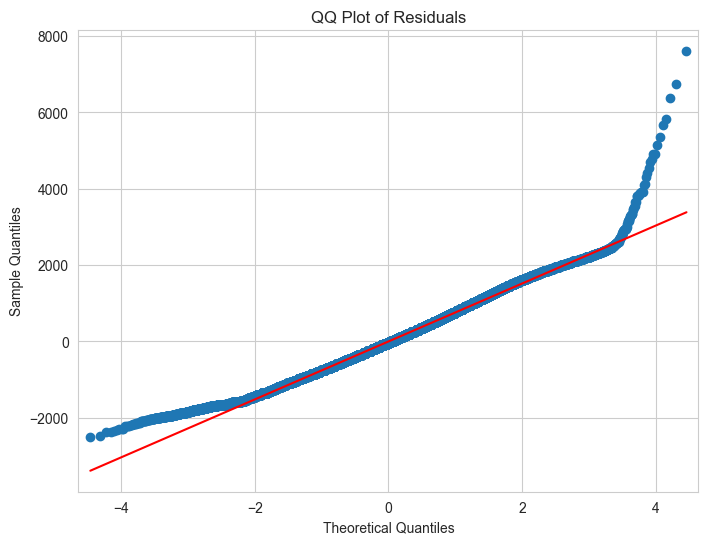

In [576]:
residuals = mod1_result.resid

# Plot residuals
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, line='s', ax=ax)
plt.title("QQ Plot of Residuals")
plt.show()

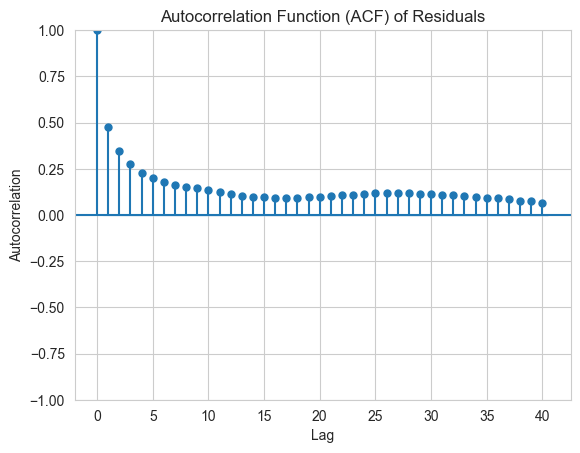

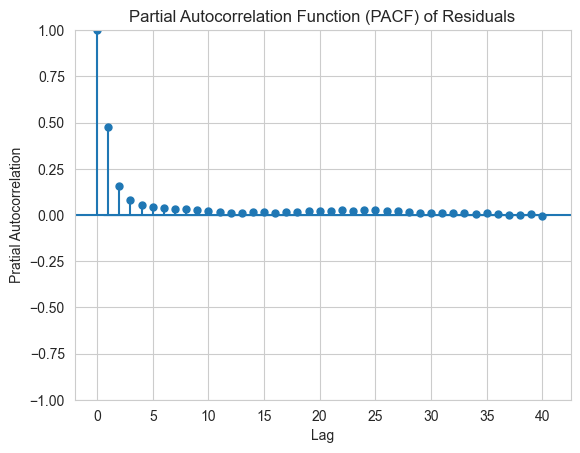

In [577]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(mod1_result.resid, lags=40)  # Adjust the number of lags as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()

plot_pacf(mod1_result.resid, lags=40)  # Adjust the number of lags as needed
plt.xlabel('Lag')
plt.ylabel('Pratial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.show()

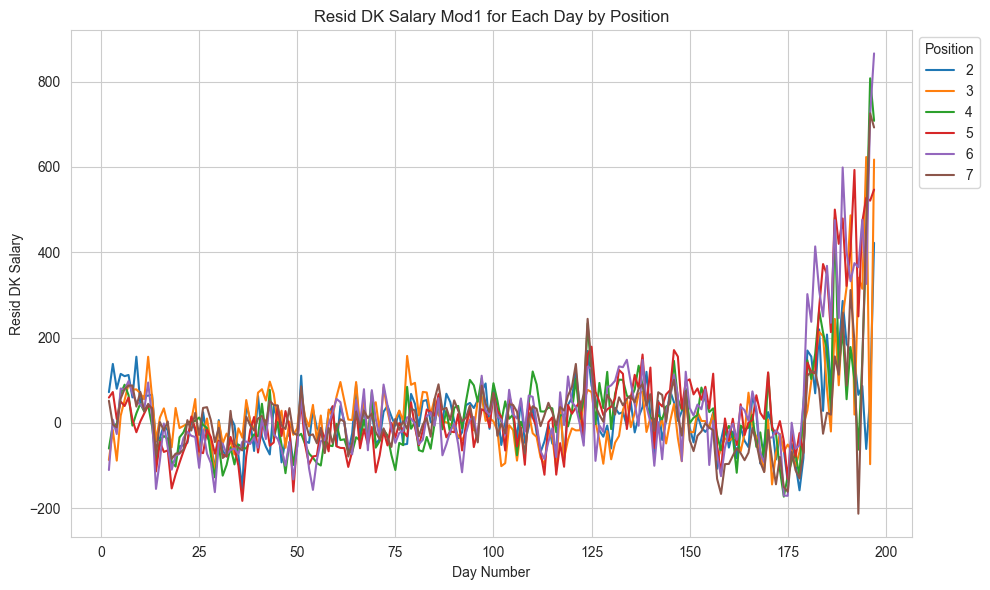

In [578]:
mod1_df = train_dk_df.copy()[['year', 'day_num', 'Position']]
mod1_df['resid'] = mod1_result.resid

grouped_df = mod1_df.groupby(['day_num','Position'])['resid'].mean().unstack()

plt.figure(figsize=(10, 6))
for column in grouped_df.columns:
    plt.plot(grouped_df.index, grouped_df[column], label=str(column))

plt.xlabel('Day Number')
plt.ylabel('Resid DK Salary') 
plt.title('Resid DK Salary Mod1 for Each Day by Position')
plt.legend(title='Position', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [623]:
test_dk_df.drop(['dk_salary_lagged'], axis=1, inplace=True)

In [628]:
test_dk_df

,Position,Name,dk_points,dk_salary,Team,Opp,Score,year,hits,abs,...,away_sea,away_sfo,away_stl,away_tam,away_tex,away_tor,away_was,day_num_x,day_num_y,day_num
247825,7,Kike Hernandez,33.0,3600.0,home_LAD,away_sfo,8-1,2020,4,5,...,False,True,False,False,False,False,False,1,1,1
247826,7,Giancarlo Stanton,21.0,4600.0,home_NYY,away_was,4-1(F6),2020,2,3,...,False,False,False,False,False,False,True,1,1,1
247827,7,Adam Eaton,14.0,3800.0,home_WAS,away_nyy,1-4(F6),2020,1,2,...,False,False,False,False,False,False,False,1,1,1
247828,5,Justin Turner,13.0,4100.0,home_LAD,away_sfo,8-1,2020,1,4,...,False,True,False,False,False,False,False,1,1,1
247829,7,Aaron Judge,12.0,4400.0,home_NYY,away_was,4-1(F6),2020,2,3,...,False,False,False,False,False,False,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264152,4,Kike Hernandez,0.0,3000.0,home_LAD,away_atl,3-1,2020,0,4,...,False,False,False,False,False,False,False,81,81,81
264153,5,Pablo Sandoval,0.0,3000.0,home_ATL,away_lad,1-3,2020,0,1,...,False,False,False,False,False,False,False,81,81,81
264154,7,Kevin Kiermaier,0.0,2800.0,home_TAM,away_hou,4-2,2020,0,3,...,False,False,False,False,False,False,False,81,81,81
264155,7,Josh Reddick,0.0,2700.0,home_HOU,away_tam,2-4,2020,0,4,...,False,False,False,True,False,False,False,81,81,81


In [639]:
from sklearn.metrics import mean_squared_error
import numpy as np

test_dk_df['dk_salary_lagged'] = test_dk_df.groupby(['Name'])['dk_salary'].shift(1)

In [641]:
test_dk_df.dropna(subset=['dk_salary_lagged'], inplace=True)
test_dk_df[['dk_salary_lagged', 'dk_points']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 15753 entries, 247862 to 264156
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dk_salary_lagged  15753 non-null  float64
 1   dk_points         15753 non-null  float64
dtypes: float64(2)
memory usage: 369.2 KB


In [643]:
def get_mse_and_rmse(df, model_result):
    actual = df['dk_salary_lagged']
    pred = model_result.predict(df)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    
    return mse, rmse

In [644]:
mse1, rmse1 = get_mse_and_rmse(test_dk_df, mod1_result)

In [646]:
print("Model 1 MSE: " + str(mse1))
print("Model 1 RMSE: " + str(rmse1))

Model 1 MSE: 924244.3546799244
Model 1 RMSE: 961.376281525566


a### Mod2

In [656]:
def plot_residuals(residuals, df):

    fig, ax = plt.subplots(figsize=(8, 6))
    sm.qqplot(residuals, line='s', ax=ax)
    plt.title("QQ Plot of Residuals")
    plt.show() 
   
    plot_acf(residuals, lags=40)  # Adjust the number of lags as needed
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Function (ACF) of Residuals')
    plt.show()

    plot_pacf(residuals, lags=40)  # Adjust the number of lags as needed
    plt.xlabel('Lag')
    plt.ylabel('Pratial Autocorrelation')
    plt.title('Partial Autocorrelation Function (PACF) of Residuals')
    plt.show() 
   
    mod_df = df.copy()[['year', 'day_num', 'Position']]
    mod_df['resid'] = residuals 

    grouped_df = mod_df.groupby(['day_num','Position'])['resid'].mean().unstack()

    plt.figure(figsize=(10, 6))
    for column in grouped_df.columns:
        plt.plot(grouped_df.index, grouped_df[column], label=str(column))

    plt.xlabel('Day Number')
    plt.ylabel('Resid DK Salary') 
    plt.title('Resid DK Salary for Each Day by Position')
    plt.legend(title='Position', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show() 

In [580]:
train_dk_df['dk_salary_lagged'].dropna(inplace=True)

In [581]:
train_dk_df['avg_hit_distance'].fillna(train_dk_df['avg_hit_distance'].mean(), inplace=True)
train_dk_df['avg_launch_speed'].fillna(train_dk_df['avg_launch_speed'].mean(), inplace=True) 
train_dk_df['avg_launch_angle'].fillna(train_dk_df['avg_launch_angle'].mean(), inplace=True)
train_dk_df['estimated_ba_using_speedangle'].fillna(train_dk_df['estimated_ba_using_speedangle'].mean(),
                                                    inplace=True)
train_dk_df['estimated_woba_using_speedangle'].fillna(train_dk_df['estimated_woba_using_speedangle'].mean(),
                                                      inplace=True) 

In [589]:
train_dk_df.dropna(subset=['dk_salary_lagged'], inplace=True)

In [590]:
mod2 = smf.mixedlm('dk_salary_lagged ~ dk_points + avg_hit_distance + avg_launch_speed + avg_launch_angle + estimated_ba_using_speedangle + estimated_woba_using_speedangle', 
                   train_dk_df, 
                   groups=train_dk_df["Position"])
mod2_result = mod2.fit() 

In [591]:
mod2_result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
==================================================================================
Model:                    MixedLM       Dependent Variable:       dk_salary_lagged
No. Observations:         244690        Method:                   REML            
No. Groups:               6             Scale:                    574061.3025     
Min. group size:          22594         Log-Likelihood:           -1969568.5578   
Max. group size:          83943         Converged:                Yes             
Mean group size:          40781.7                                                 
----------------------------------------------------------------------------------
                                  Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------------
Intercept                        3207.387   89.763  35.732 0.000 3031.455 3383.319
dk_points                          22.813    0.257  88.853 0.000   22.310   23.316
avg_hit_distance                   -0.404    0.032 -12.797 0.000   -0.466   -0.342
avg_launch_speed                    3.757    0.207  18.155 0.000    3.352    4.163
avg_launch_angle                    2.274    0.125  18.258 0.000    2.030    2.518
estimated_ba_using_speedangle    -142.111   20.228  -7.026 0.000 -181.756 -102.465
estimated_woba_using_speedangle   -35.445   16.755  -2.116 0.034  -68.284   -2.606
Group Var                       46773.828   36.360                                
==================================================================================

"""

In [592]:
from scipy.stats import chi2

def lrt(mod1_result, mod2_result, dif):
    llf_diff = mod1_result.llf - mod2_result.llf

    test_stat = -2 * llf_diff
    p_value = 1 - chi2.cdf(test_stat, dif)

    print("Likelihood Ratio Test (LRT) Results:")
    print("Test statistic:", test_stat)
    print("P-value:", p_value)
    
lrt(mod1_result, mod2_result, 5)

Likelihood Ratio Test (LRT) Results:
Test statistic: 922.1290346514434
P-value: 0.0


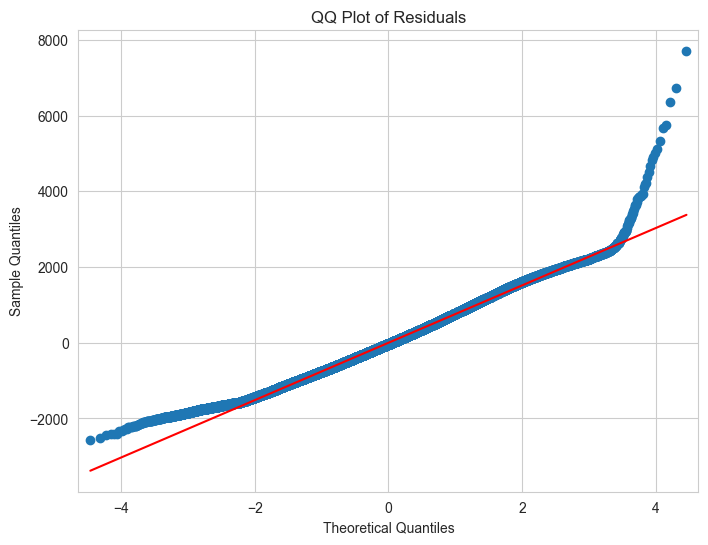

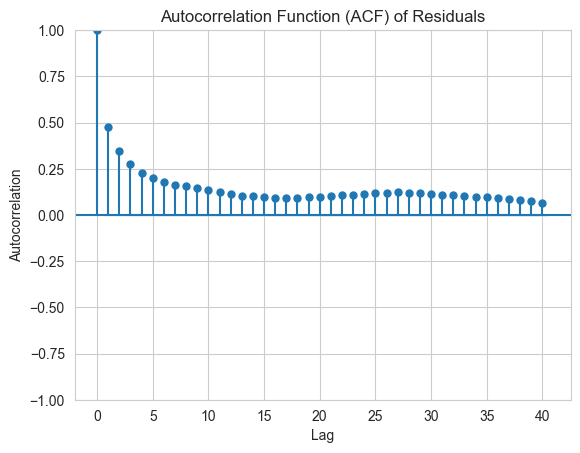

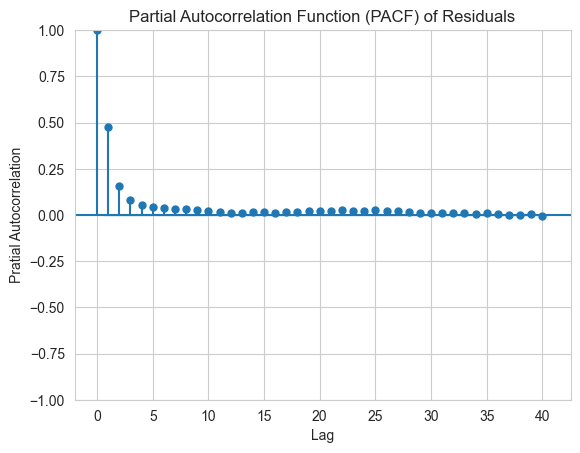

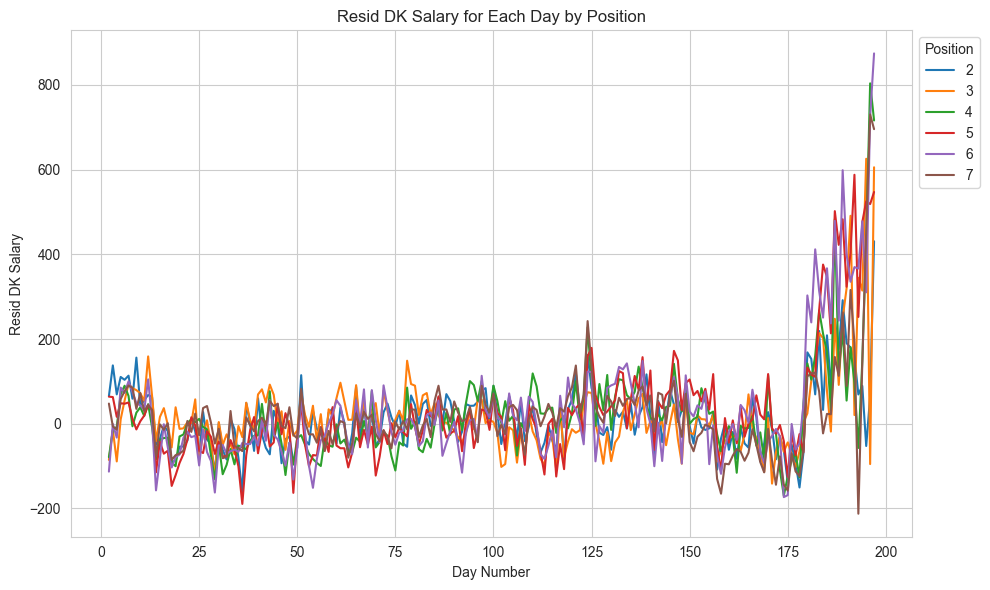

In [657]:
plot_residuals(mod2_result.resid, train_dk_df)

In [647]:
test_dk_df['avg_hit_distance'].fillna(test_dk_df['avg_hit_distance'].mean(), inplace=True)
test_dk_df['avg_launch_speed'].fillna(test_dk_df['avg_launch_speed'].mean(), inplace=True) 
test_dk_df['avg_launch_angle'].fillna(test_dk_df['avg_launch_angle'].mean(), inplace=True)
test_dk_df['estimated_ba_using_speedangle'].fillna(test_dk_df['estimated_ba_using_speedangle'].mean(),
                                                    inplace=True)
test_dk_df['estimated_woba_using_speedangle'].fillna(test_dk_df['estimated_woba_using_speedangle'].mean(),
                                                      inplace=True) 

In [648]:
mse2, rmse2 = get_mse_and_rmse(test_dk_df, mod2_result)

In [650]:
print("Model 2 MSE: " + str(mse2))
print("Model 2 RMSE: " + str(rmse2))

Model 2 MSE: 920187.7236394507
Model 2 RMSE: 959.2641573828612


In [594]:
import numpy as np
train_dk_df['game_date'] = pd.to_datetime(train_dk_df['game_date'])
train_dk_df['day_of_week'] = train_dk_df['game_date'].dt.dayofweek
train_dk_df['angular_date'] = 2 * np.pi * train_dk_df['day_of_week'] / 7

In [595]:
mod3 = smf.mixedlm('dk_salary_lagged ~ dk_points + avg_hit_distance + avg_launch_speed + avg_launch_angle + estimated_ba_using_speedangle + estimated_woba_using_speedangle + angular_date', 
                   train_dk_df, 
                   groups=train_dk_df["Position"])
mod3_result = mod3.fit() 

In [596]:
mod3_result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
==================================================================================
Model:                    MixedLM       Dependent Variable:       dk_salary_lagged
No. Observations:         244690        Method:                   REML            
No. Groups:               6             Scale:                    573982.3794     
Min. group size:          22594         Log-Likelihood:           -1969550.4673   
Max. group size:          83943         Converged:                Yes             
Mean group size:          40781.7                                                 
----------------------------------------------------------------------------------
                                  Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------------
Intercept                        3222.811   89.795  35.891 0.000 3046.817 3398.806
dk_points                          22.808    0.257  88.842 0.000   22.305   23.312
avg_hit_distance                   -0.405    0.032 -12.818 0.000   -0.467   -0.343
avg_launch_speed                    3.747    0.207  18.105 0.000    3.341    4.152
avg_launch_angle                    2.284    0.125  18.338 0.000    2.040    2.529
estimated_ba_using_speedangle    -142.261   20.226  -7.033 0.000 -181.904 -102.618
estimated_woba_using_speedangle   -35.244   16.754  -2.104 0.035  -68.081   -2.407
angular_date                       -5.069    0.861  -5.886 0.000   -6.758   -3.381
Group Var                       46767.290   36.357                                
==================================================================================

"""

In [597]:
lrt(mod2_result, mod3_result, 1)

Likelihood Ratio Test (LRT) Results:
Test statistic: 36.18108244007453
P-value: 1.7980756883417826e-09


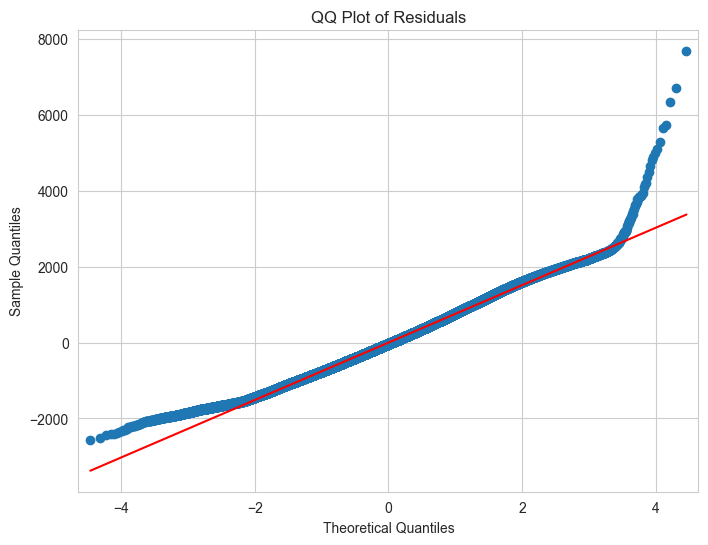

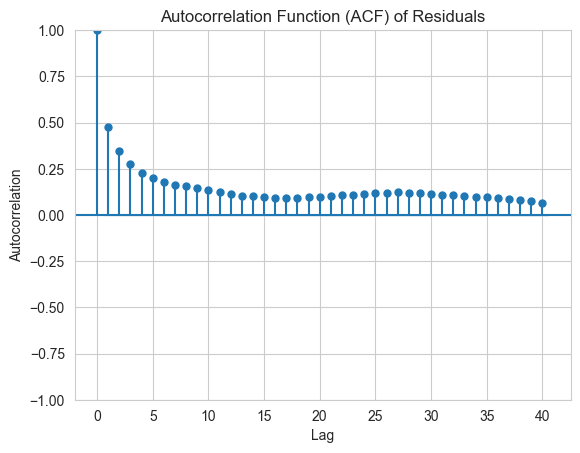

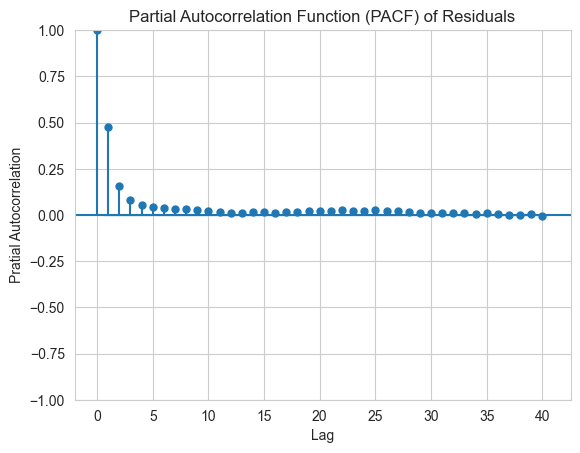

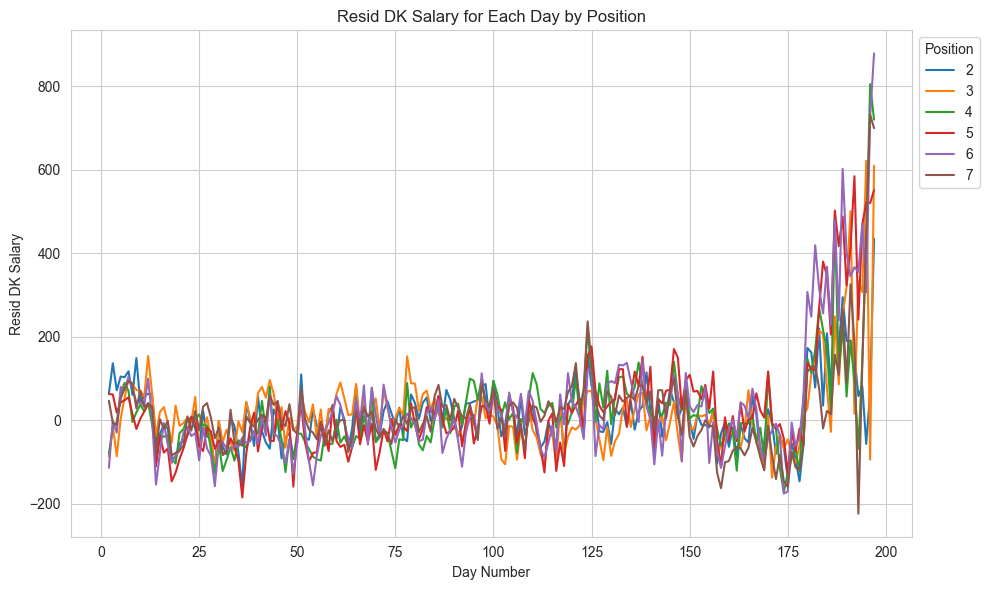

In [658]:
plot_residuals(mod3_result.resid, train_dk_df)

In [651]:
test_dk_df['game_date'] = pd.to_datetime(test_dk_df['game_date'])
test_dk_df['day_of_week'] = test_dk_df['game_date'].dt.dayofweek
test_dk_df['angular_date'] = 2 * np.pi * test_dk_df['day_of_week'] / 7

In [653]:
mse3, rmse3 = get_mse_and_rmse(test_dk_df, mod3_result)
print("Model 3 MSE: " + str(mse3))
print("Model 3 RMSE: " + str(rmse3))

Model 3 MSE: 919728.957163428
Model 3 RMSE: 959.0250034088933


In [599]:
train_dk_df['salary_lagged_2'] = train_dk_df.groupby(['Name', 'year'])['dk_salary_lagged'].shift(1)
train_dk_df['salary_lagged_3'] = train_dk_df.groupby(['Name', 'year'])['dk_salary_lagged'].shift(2)
train_dk_df['salary_lagged_4'] = train_dk_df.groupby(['Name', 'year'])['dk_salary_lagged'].shift(3)
train_dk_df['salary_lagged_5'] = train_dk_df.groupby(['Name', 'year'])['dk_salary_lagged'].shift(4)

In [600]:
train_dk_df.salary_lagged_2.dropna(inplace=True)
train_dk_df.salary_lagged_3.dropna(inplace=True)
train_dk_df.salary_lagged_4.dropna(inplace=True)
train_dk_df.salary_lagged_5.dropna(inplace=True)

In [601]:
train_dk_df.dropna(subset=['salary_lagged_5'], inplace=True)

In [602]:
train_dk_df[['dk_salary_lagged', 'dk_points', 'avg_hit_distance', 'avg_launch_speed',
             'avg_launch_angle', 'estimated_ba_using_speedangle',
             'estimated_woba_using_speedangle','angular_date',
             'salary_lagged_2','salary_lagged_3', 'salary_lagged_4','salary_lagged_5']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 232461 entries, 1216 to 247824
Data columns (total 12 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   dk_salary_lagged                 232461 non-null  float64
 1   dk_points                        232461 non-null  float64
 2   avg_hit_distance                 232461 non-null  float64
 3   avg_launch_speed                 232461 non-null  float64
 4   avg_launch_angle                 232461 non-null  float64
 5   estimated_ba_using_speedangle    232461 non-null  float64
 6   estimated_woba_using_speedangle  232461 non-null  float64
 7   angular_date                     232461 non-null  float64
 8   salary_lagged_2                  232461 non-null  float64
 9   salary_lagged_3                  232461 non-null  float64
 10  salary_lagged_4                  232461 non-null  float64
 11  salary_lagged_5                  232461 non-null  float64
dtypes: f

In [603]:
mod4 = smf.mixedlm('dk_salary_lagged ~ dk_points + avg_hit_distance + avg_launch_speed '
                   '+ avg_launch_angle + estimated_ba_using_speedangle '
                   '+ estimated_woba_using_speedangle + angular_date '
                   '+ salary_lagged_2 + salary_lagged_3 + salary_lagged_4'
                   '+ salary_lagged_5', 
                   train_dk_df, 
                   groups=train_dk_df["Position"]) 
mod4_result = mod4.fit() 

In [604]:
lrt(mod3_result, mod4_result, 4)

Likelihood Ratio Test (LRT) Results:
Test statistic: 598953.9383860873
P-value: 0.0


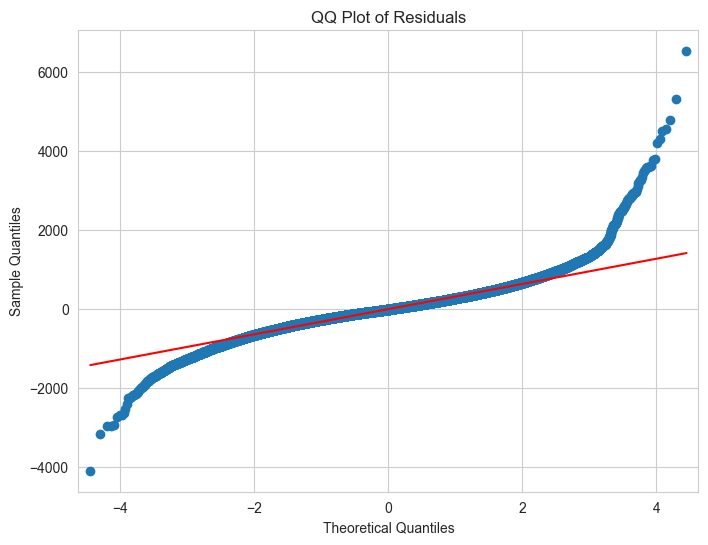

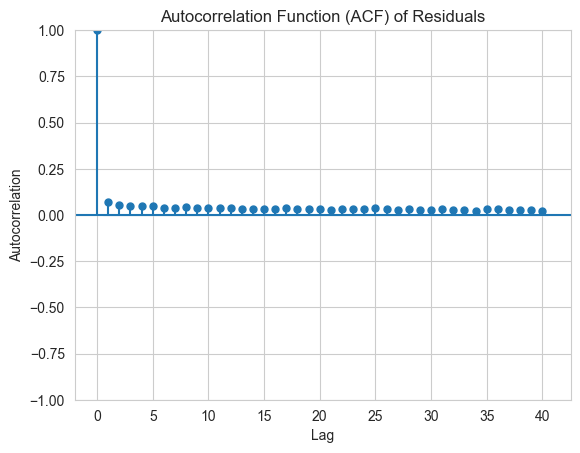

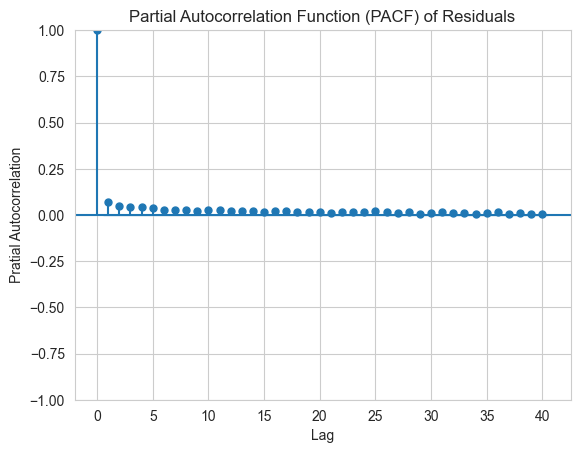

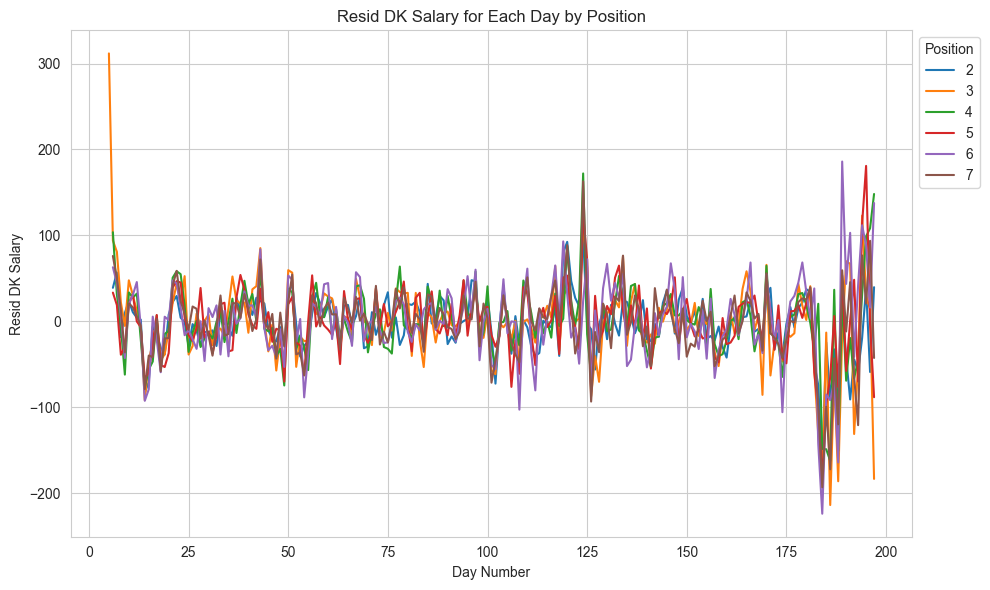

In [659]:
plot_residuals(mod4_result.resid, train_dk_df)

In [654]:
test_dk_df['salary_lagged_2'] = test_dk_df.groupby(['Name', 'year'])['dk_salary_lagged'].shift(1)
test_dk_df['salary_lagged_3'] = test_dk_df.groupby(['Name', 'year'])['dk_salary_lagged'].shift(2)
test_dk_df['salary_lagged_4'] = test_dk_df.groupby(['Name', 'year'])['dk_salary_lagged'].shift(3)
test_dk_df['salary_lagged_5'] = test_dk_df.groupby(['Name', 'year'])['dk_salary_lagged'].shift(4)
test_dk_df.dropna(subset=['salary_lagged_5'], inplace=True)

In [655]:
mse4, rmse4 = get_mse_and_rmse(test_dk_df, mod4_result)
print("Model 4 MSE: " + str(mse4))
print("Model 4 RMSE: " + str(rmse4))

Model 4 MSE: 101328.4991511831
Model 4 RMSE: 318.32137715080194


### Residual plots of test data

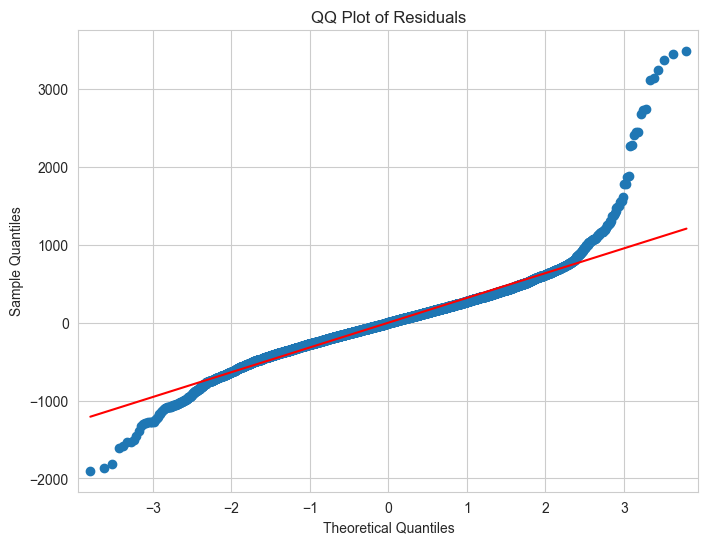

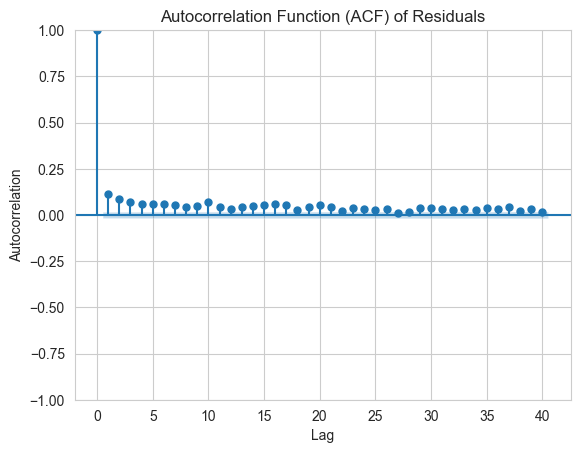

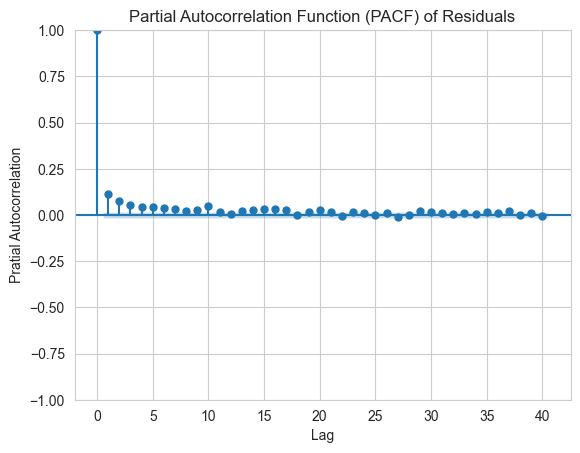

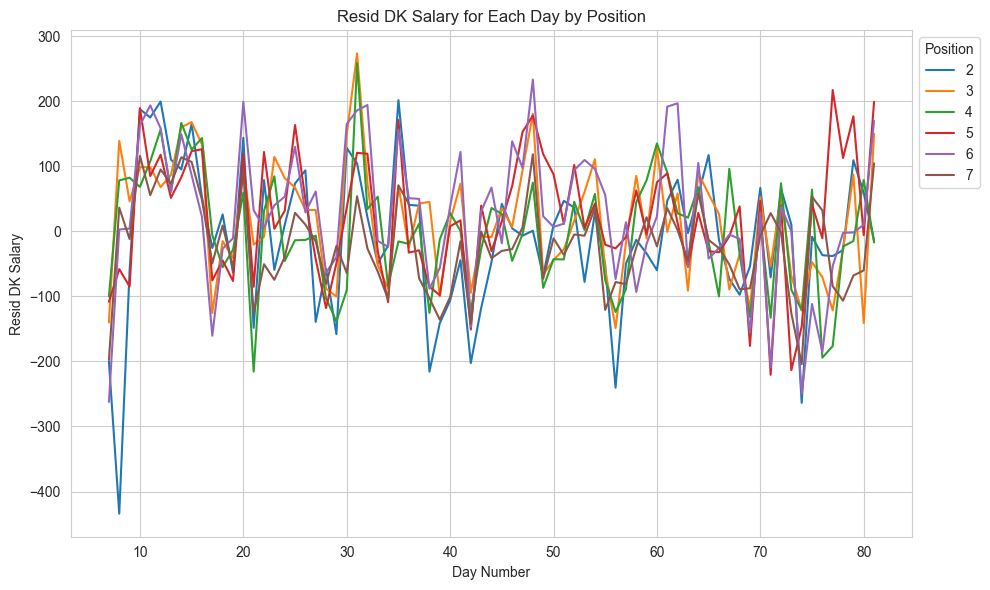

In [662]:

actual = test_dk_df['dk_salary_lagged']
predicted = mod4_result.predict(test_dk_df)
plot_residuals(actual - predicted, test_dk_df)

### Resid plots over the years

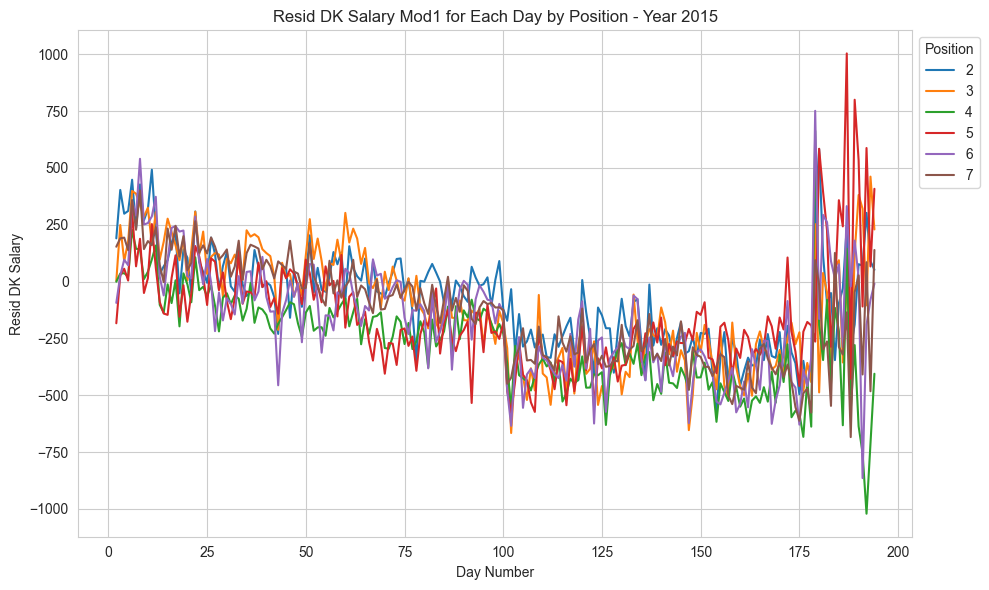

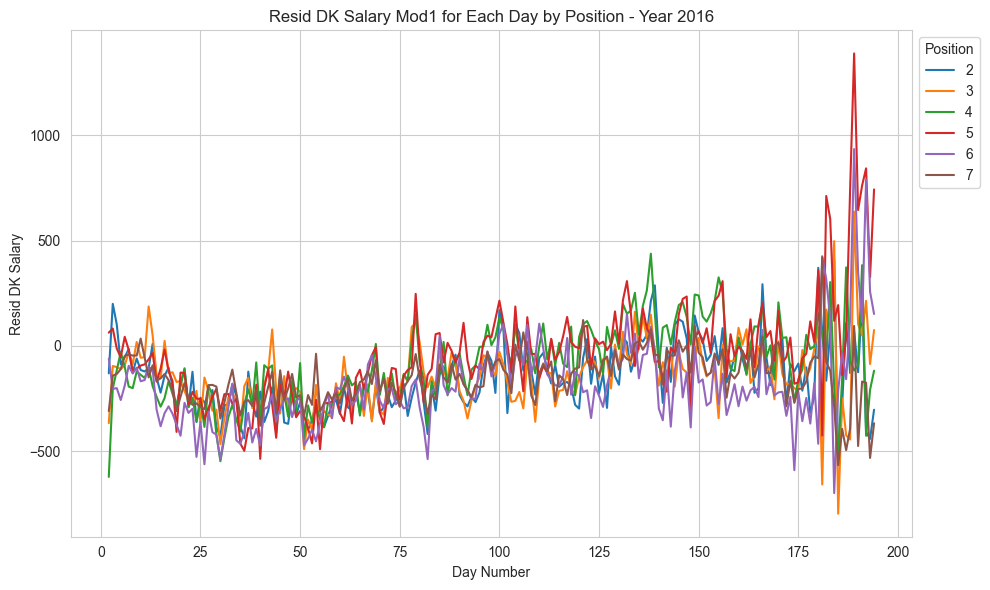

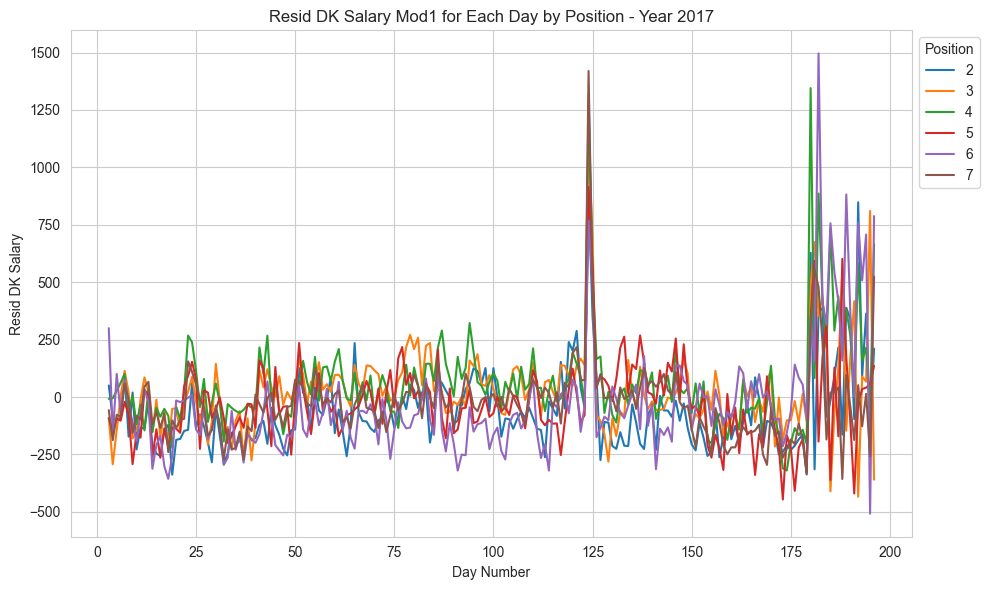

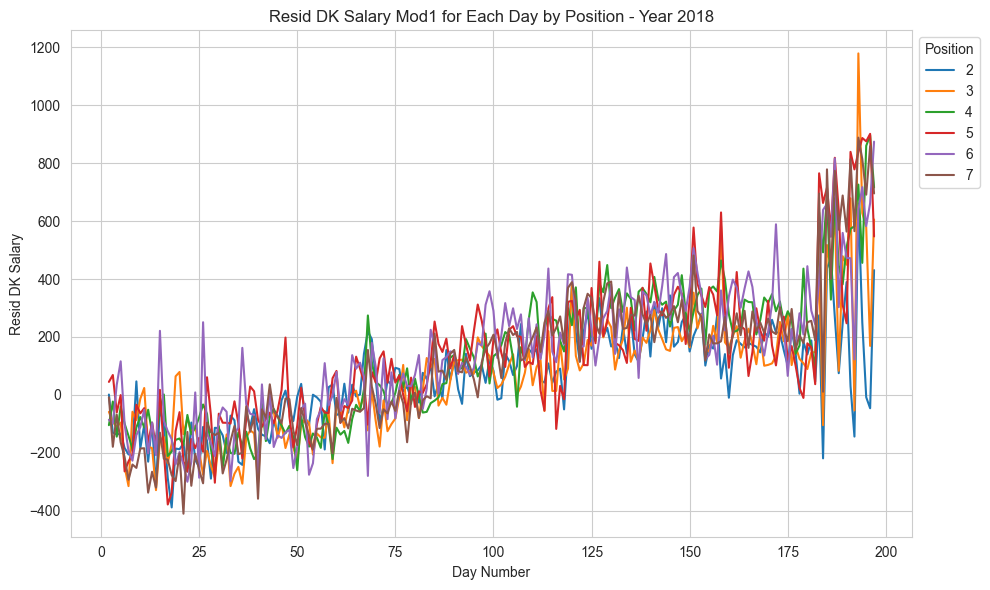

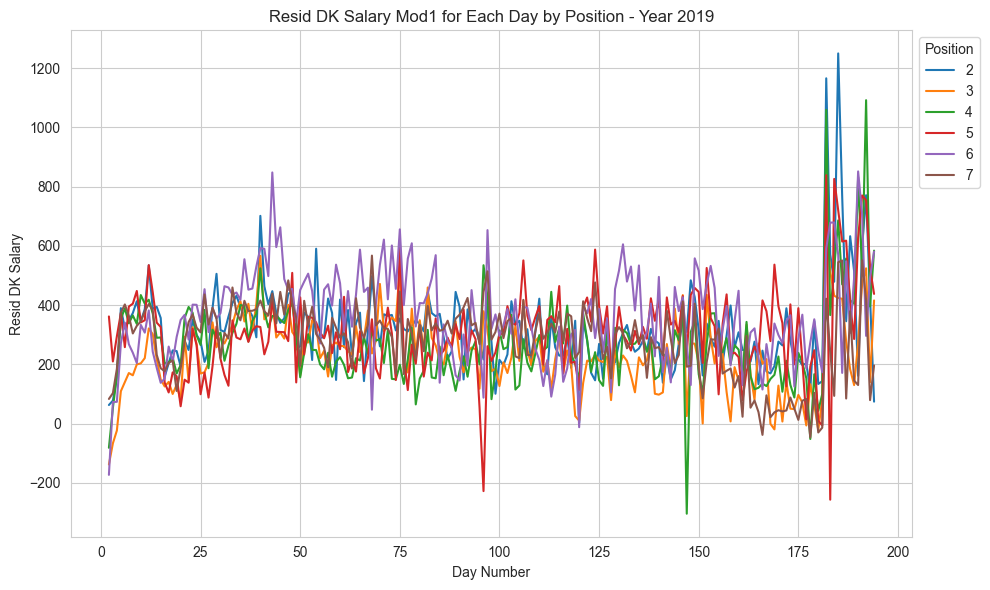

In [660]:
mod2_df = train_dk_df.copy()[['year', 'day_num', 'Position']]
mod2_df['resid'] = mod2_result.resid

grouped_df = mod2_df.groupby(['day_num', 'year','Position'])['resid'].mean().unstack()

for year, year_group in grouped_df.groupby(level='year'):
    plt.figure(figsize=(10, 6))
    for position in year_group.columns:
        plt.plot(year_group.index.get_level_values('day_num'), year_group[position], label=str(position))
    plt.xlabel('Day Number')
    plt.ylabel('Resid DK Salary') 
    plt.title(f'Resid DK Salary Mod1 for Each Day by Position - Year {year}')
    plt.legend(title='Position', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Boosting

In [663]:
import xgboost as xgb

train_x = train_dk_df[['dk_points', 'avg_hit_distance', 'avg_launch_speed',
                   'avg_launch_angle', 'estimated_ba_using_speedangle',
                   'estimated_woba_using_speedangle', 'angular_date',
                   'salary_lagged_2', 'salary_lagged_3', 'salary_lagged_4',
                   'salary_lagged_5']]

train_y = train_dk_df[['dk_salary_lagged']]

test_x = test_dk_df[['dk_points', 'avg_hit_distance', 'avg_launch_speed',
                   'avg_launch_angle', 'estimated_ba_using_speedangle',
                   'estimated_woba_using_speedangle', 'angular_date',
                   'salary_lagged_2', 'salary_lagged_3', 'salary_lagged_4',
                   'salary_lagged_5']]

test_y = test_dk_df[['dk_salary_lagged']]

dtrain_reg = xgb.DMatrix(train_x, train_y, enable_categorical=True)
dtest_reg = xgb.DMatrix(test_x, test_y, enable_categorical=True)

KeyError: "['angular_date', 'salary_lagged_2', 'salary_lagged_3', 'salary_lagged_4', 'salary_lagged_5'] not in index"

#  Analysis